You can find this code on my GitHub account: https://github.com/MaximilianJHuber/NYU

Question 1
==

In [1]:
using Roots
using ForwardDiff
using PyPlot

type GrowthModel
    β::Float64
    α::Float64
    A::Float64
    γ::Float64
    δ::Float64
    f::Function
    u::Function
    lom::Function
    kk2c::Function
    k_grid_min::Float64
    k_grid_max::Float64
    k_grid_size::Int
    k_grid::LinSpace{Float64}
    k_stst::Float64
    
    F::Function
    V_stst::Float64
end

function GrowthModel(k_grid_min, k_grid_max; k_grid_size=100, f=k->A*k.^α, u=c->(c.^(1-γ)-1)/(1-γ), lom=(k,c)->(1-δ)*k + f(k) .- c,
    kk2c=(k,kprime)->(1-δ)*k + f(k) .- kprime, β=0.98, α=1/3, A=1, γ=2, δ=0.05)

    F(k::Vector) = u(kk2c(k[1], k[2]))
    eulersteady(k) = reshape(ForwardDiff.gradient(F,[k,k])' * [β,1], 1)[1]
    k_stst = fzero(eulersteady, 0.5, 60)
    
    k_grid = linspace(k_stst*k_grid_min, k_stst*k_grid_max, k_grid_size)
    
    V_stst = F([k_stst, k_stst])*1/(1-β)
    
    return GrowthModel(β,α,A,γ,δ,f,u,lom,kk2c,k_grid_min,k_grid_max,k_grid_size,k_grid,k_stst,F,V_stst)
end

GrowthModel

In [2]:
function myVFI(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)     #old continuation value function at grid points
    V_next = Array(Float64, m.k_grid_size)   #new value function
    policy = Array(Int64, m.k_grid_size)     #grid index of optimal choice
    current = Array(Float64, m.k_grid_size)  #current utility (as opposed to continuation value)
    
    t = 0
    err = 1.
    
    while err>=threshold && t <= max_iter
        t += 1
        
        for (i,k) in enumerate(m.k_grid) #state
            
            for (j,y) in enumerate(m.k_grid) #control
                # choice is feasible iff c >= 0
                current[j] = m.kk2c(k,y) >= 0 ? m.F([k, y]) : -Inf
            end
            
            policy[i] = indmax(current .+ m.β*V_old)
            V_next[i] = current[policy[i]] + m.β*V_old[policy[i]]
        end
        
        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t)
end

myVFI (generic function with 1 method)

1.1
--

In [3]:
benchmark = GrowthModel(0.95,1.05,k_grid_size=200);
(benchmark.k_stst, benchmark.V_stst)

(10.301099814055606,19.89383775746739)

In [5]:
@time (V_next, policy, t) = myVFI(benchmark);
t

 13.908865 seconds (166.85 M allocations: 3.044 GB, 3.42% gc time)


181

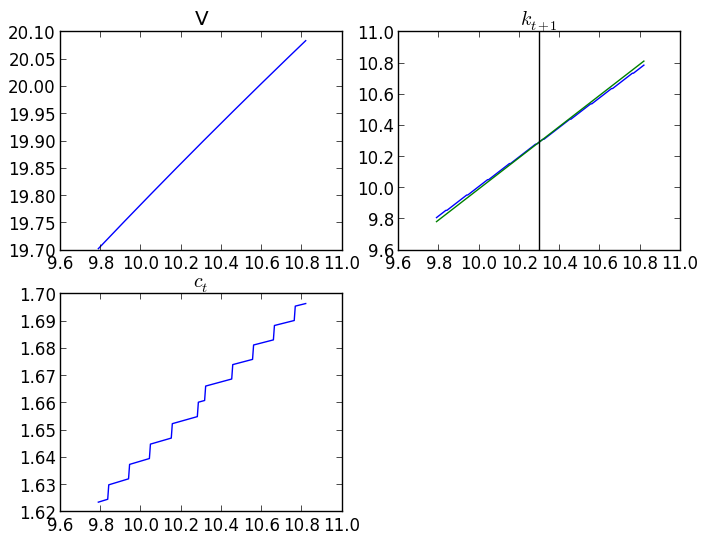

In [6]:
subplot(221)
plot(benchmark.k_grid, V_next)
title("V")
subplot(222)
plot(benchmark.k_grid, benchmark.k_grid[policy])
plot(benchmark.k_grid,benchmark.k_grid)
axvline(benchmark.k_stst, color="k")
title(L"$k_{t+1}$")
subplot(223)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid,benchmark.k_grid[policy]));
title(L"$c_{t}$");

1.2.
--

In [7]:
function myVFIvect(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)     #old continuation value function at grid points
    V_next = zeros(Float64, m.k_grid_size)   #new value function
    policy = zeros(Int64, m.k_grid_size)     #grid index of optimal choice
    
    F_mat = zeros(Float64,m.k_grid_size,m.k_grid_size)  #rows: choices, cols: states
    V_try = zeros(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: states
    
    t = 0
    err = 1.
    
    for (i,y) in enumerate(m.k_grid) #control    
        for (j,k) in enumerate(m.k_grid) #state
            F_mat[i,j] = m.kk2c(k,y) >= 0 ? m.F([k, y]) : -Inf
        end
    end
    
    while err>=threshold && t <= max_iter
        t += 1
        
        V_try = F_mat + m.β .* hcat([V_old for j=1:m.k_grid_size]...)
        
        for (i,k) in enumerate(m.k_grid) #state
            policy[i] = indmax(V_try[:,i])
            V_next[i] = V_try[policy[i],i]
        end
        
        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t)
end

myVFIvect (generic function with 1 method)

In [9]:
@time (V_next, policy, t) = myVFIvect(benchmark);

  0.399651 seconds (1.07 M allocations: 247.904 MB, 14.07% gc time)


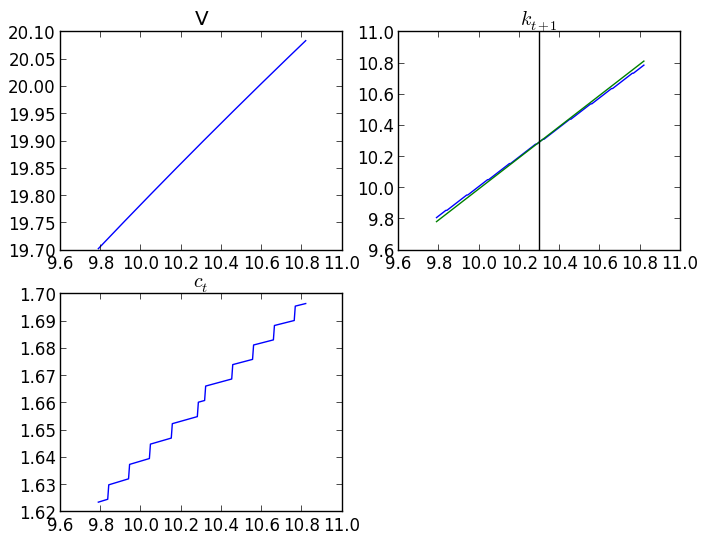

In [10]:
subplot(221)
plot(benchmark.k_grid, V_next)
title("V")
subplot(222)
plot(benchmark.k_grid, benchmark.k_grid[policy])
plot(benchmark.k_grid,benchmark.k_grid)
axvline(benchmark.k_stst, color="k")
title(L"$k_{t+1}$")
subplot(223)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid,benchmark.k_grid[policy]));
title(L"$c_{t}$");

The vectorization yields a performance boost of factor 35!

1.3.
--
I give the code another makeover and use:

QuantEcon: Discrete Dynamic Programming 
--
The following is a rehash of my contribution to the "Discrete Dynamic Programming" lecture on QuantEcon, see: http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.applications/blob/master/discrete_dp/discrete_dp_solutions_jl.ipynb

In [11]:
using QuantEcon

function destill_ddp(m::GrowthModel)
    C = m.kk2c(m.k_grid'',m.k_grid')                         #consumptions 
    coord = repmat(collect(1:m.k_grid_size),1,m.k_grid_size) #coordinates
    s_indices = coord[C.>0]                                  #feasible state coordinates
    a_indices = transpose(coord)[C.>0]                       #feasible action coordinates
    L = length(a_indices)

    Q = spzeros(L,m.k_grid_size)

    for i in 1:L
        Q[i,a_indices[i]] = 1
    end

    R = m.u(C[C.>0]) #reward

    return DiscreteDP(R, Q, m.β, s_indices, a_indices);
end

benchmark = GrowthModel(0.5,1.5,k_grid_size=200);
ddp = destill_ddp(benchmark);

In [13]:
@time results = solve(ddp,VFI);

  0.272796 seconds (5.80 k allocations: 148.877 MB, 22.34% gc time)


Even faster!

In [14]:
function init_shooting(m::GrowthModel,k0::Real)
    
    return function shooting(guess,path=false)
        k=Array(Float64,200)
        k[1]=k0*m.k_stst; k[2]=guess

        for t in 3:200
            k[t] = -(((((1-m.δ)*k[t-2]+k[t-2]^m.α-k[t-1])^(-m.γ))/m.β/((1-m.δ)+m.α*k[t-1]^(m.α-1)))^(-1/m.γ) - 
            ((1-m.δ)*k[t-1] + k[t-1]^m.α))
        
            k[t] = maximum([eps(Float64),k[t]])
        end

        if path
            return k
        else
            return k[200]-m.k_stst
        end
    end
    
end

init_shooting (generic function with 1 method)

In [15]:
shooting = init_shooting(benchmark, 1/2)
k12_guess = fzero(shooting,5,6)
k12_path = shooting(k12_guess,true)
shooting = init_shooting(benchmark, 3/2)
k32_guess = fzero(shooting,14,16)
k32_path = shooting(k32_guess,true);

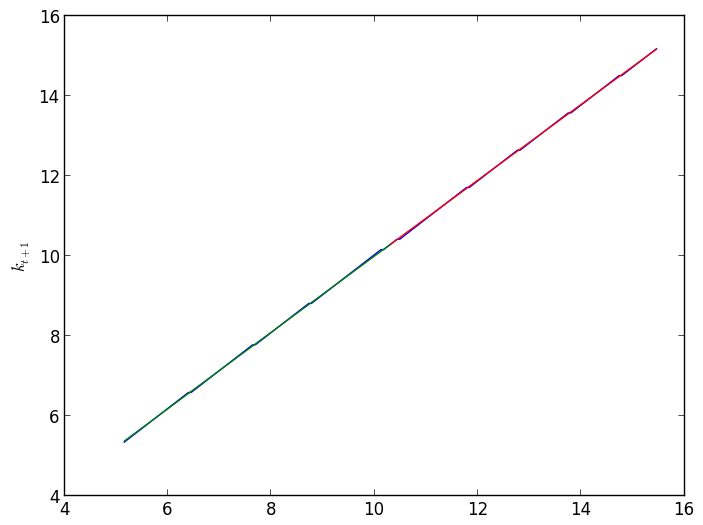

In [16]:
plot(benchmark.k_grid, benchmark.k_grid[results.sigma])
ylabel(L"$k_{t+1}$")
plot(k12_path[1:(length(k12_path)-1)], k12_path[2:end])
plot(k32_path[1:(length(k32_path)-1)], k32_path[2:end]);

The solutions are visually close, but still off a bit!

1.4.
--

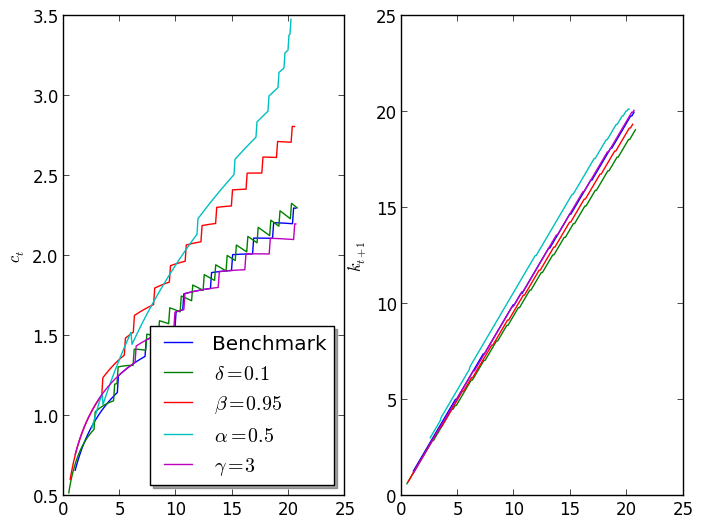

In [17]:
benchmark = GrowthModel(0.1,2,k_grid_size=200)
subplot(121)
plot(benchmark.k_grid, benchmark.kk2c(benchmark.k_grid, benchmark.k_grid[solve(destill_ddp(benchmark)).sigma]), label="Benchmark")
ylabel(L"$c_t$")

subplot(122)
plot(benchmark.k_grid, benchmark.k_grid[solve(destill_ddp(benchmark)).sigma])
ylabel(L"$k_{t+1}$")

model = GrowthModel(0.1,4.5,k_grid_size=200, δ=0.1)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\delta=0.1$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.1,3.5,k_grid_size=200, β=0.95)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\beta=0.95$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.05,0.4,k_grid_size=200, α=0.5)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\alpha=0.5$")
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma])

model = GrowthModel(0.1,2,k_grid_size=200, γ=3)
subplot(121)
plot(model.k_grid, model.kk2c(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]),label=L"$\gamma=3$")
legend(loc="lower right", shadow=true);
subplot(122)
plot(model.k_grid, model.k_grid[solve(destill_ddp(model)).sigma]);

A higher depreciation makes investment less profitable, hence the lower $k_{t+1}$. When $\beta$ decreases, the agent becomes less patient and saves less. The increased $\alpha$ leads to higher productivity. The lower IES, $\gamma$, tilts the tradeoff more in favor of saving. The lower $\beta$ lets the algorithm converge faster, because the $\beta$ is the factor of contraction of the Bellman operator.

1.5.
--

In [18]:
using Interpolations

function myVFIinterp(m::GrowthModel; threshold=1e-4, max_iter=1000)
    
    V_old = m.V_stst*ones(m.k_grid_size)    #old continuation value function at grid points
    V_next = zeros(Float64, m.k_grid_size)   #new value function
    policy = zeros(Int64, m.k_grid_size)     #grid index of optimal choice
    
    c_grid = linspace(0, 5, m.k_grid_size)
    
    G = m.lom(m.k_grid'',c_grid')'           #rows: choices, cols: states
    F_mat = hcat([m.u(c_grid) for j=1:m.k_grid_size]...)
    F_mat[G.<m.k_stst*m.k_grid_min] = -Inf
    F_mat[G.>m.k_stst*m.k_grid_max] = -Inf
    
    V_try = zeros(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: states

    t = 0
    err = 1.
    
    while err>=threshold && t <= max_iter
        t += 1
        Aw = scale(interpolate(V_old, BSpline(Linear()), OnGrid()), m.k_grid)
        
        V_try = F_mat + m.β .* reshape(map(x->Aw[x], G[:]),m.k_grid_size,m.k_grid_size)
        
        for (i,k) in enumerate(m.k_grid) #state
            policy[i] = indmax(V_try[:,i])
            V_next[i] = V_try[policy[i],i]
        end

        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t, c_grid)
end

myVFIinterp (generic function with 1 method)

In [20]:
benchmark=GrowthModel(0.5,1.5,k_grid_size=100);
@time (V_next, policy, t, c_grid) = myVFIinterp(benchmark);
t

  0.343405 seconds (5.88 M allocations: 203.295 MB, 10.96% gc time)


288

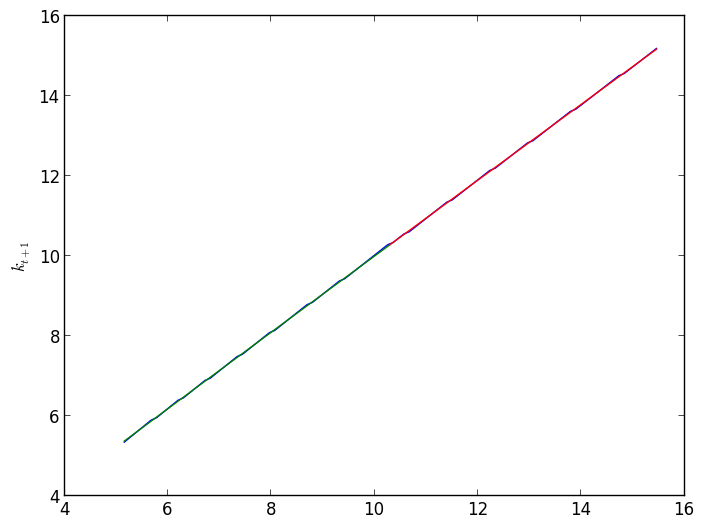

In [21]:
plot(benchmark.k_grid, benchmark.lom(benchmark.k_grid,c_grid[policy]))
ylabel(L"$k_{t+1}$")
plot(k12_path[1:(length(k12_path)-1)], k12_path[2:end])
plot(k32_path[1:(length(k32_path)-1)], k32_path[2:end]);

100 grid points give results that are very close to the shooting algorithm. The same plot in 1.3. is using 200 grid points and discrete dynamic programming looks much more jagged, though.

1.6.
--

In [22]:
function myVFIshock(m::GrowthModel; threshold=1e-4, max_iter=1000, shock=0.01)
    
    V_old = m.V_stst*ones(m.k_grid_size)    #old continuation value function at grid points
    V_next = zeros(Float64, m.k_grid_size)   #new value function
    policy = zeros(Int64, m.k_grid_size)     #grid index of optimal choice
    
    c_grid = linspace(0, 5, m.k_grid_size)
    
    G = m.lom(m.k_grid'',c_grid')'           #rows: choices, cols: states
    F_mat = hcat([m.u(c_grid) for j=1:m.k_grid_size]...)
    F_mat[G.<m.k_stst*m.k_grid_min] = -Inf
    F_mat[G.>m.k_stst*m.k_grid_max] = -Inf
    
    V_try = zeros(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: states

    t = 0
    err = 1.
    
    while err>=threshold && t <= max_iter
        t += 1
        Aw = scale(interpolate(V_old, BSpline(Linear()), OnGrid()), m.k_grid)
        
        V_try = F_mat + m.β .* (1/2*reshape(map(x->Aw[x], (1+shock)*G[:]),m.k_grid_size,m.k_grid_size)
                              + 1/2*reshape(map(x->Aw[x], (1-shock)*G[:]),m.k_grid_size,m.k_grid_size))
        
        for (i,k) in enumerate(m.k_grid) #state
            policy[i] = indmax(V_try[:,i])
            V_next[i] = V_try[policy[i],i]
        end

        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, t, c_grid)
end

myVFIshock (generic function with 1 method)

In [24]:
benchmark=GrowthModel(0.5,1.5,k_grid_size=100);
@time (V_next_shock, policy_shock, t_shock, c_grid_shock) = myVFIshock(benchmark);
t

  0.835718 seconds (11.65 M allocations: 445.192 MB, 10.82% gc time)


288

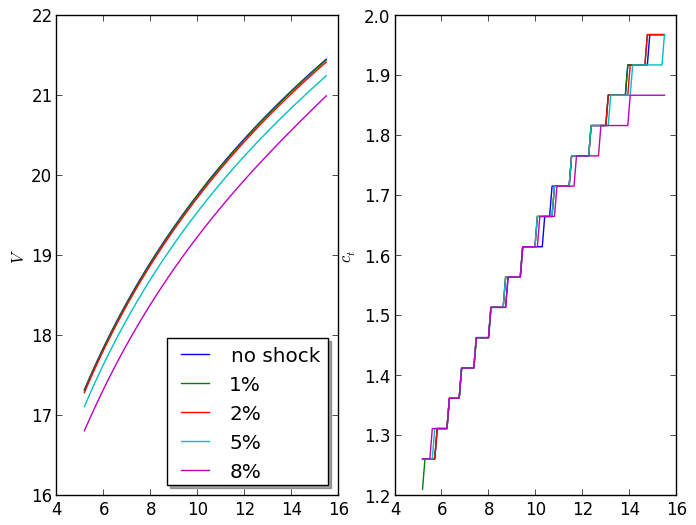

In [25]:
subplot(121)
plot(benchmark.k_grid, V_next, label="no shock")
plot(benchmark.k_grid, myVFIshock(benchmark)[1], label="1%")
plot(benchmark.k_grid, myVFIshock(benchmark,shock=0.02)[1], label="2%")
plot(benchmark.k_grid, myVFIshock(benchmark,shock=0.05)[1], label="5%")
plot(benchmark.k_grid, myVFIshock(benchmark,shock=0.08)[1], label="8%")
ylabel(L"$V$")
legend(loc="lower right",shadow=true)
subplot(122)
plot(benchmark.k_grid, c_grid[policy])
plot(benchmark.k_grid, c_grid[myVFIshock(benchmark)[2]])
plot(benchmark.k_grid, c_grid[myVFIshock(benchmark,shock=0.02)[2]])
plot(benchmark.k_grid, c_grid[myVFIshock(benchmark,shock=0.05)[2]])
plot(benchmark.k_grid, c_grid[myVFIshock(benchmark,shock=0.08)[2]])
ylabel(L"$c_{t}$");

Already at the 2% shock level, the value function decreases visibly. Optimal consumption visibly changes with a level of 5%. The curvature of the utility function decreases expected utility (Jensen's inequality). The increased shock is a mean preserving spread, the curvatur of the utility function represents risk aversion, the higher the risk the more cautious agents are, save more and consume less.

Question 3
==
2.3.b.
--

In [26]:
benchmark = GrowthModel(0,1,β = 0.95, γ = 2)
[1/2 1/2]*inv(eye(2)-benchmark.β*[1 0; 0 1])*benchmark.u([1. 5.])'

1x1 Array{Float64,2}:
 8.0

In [27]:
[1/2 1/2]*inv(eye(2)-benchmark.β*[.5 .5; .5 .5])*benchmark.u([1. 5.])'

1x1 Array{Float64,2}:
 8.0

The consumer is indifferent!

In [28]:
highgamma = GrowthModel(0,1,β = 0.95, γ = 4)
[1/2 1/2]*inv(eye(2)-benchmark.β*[1 0; 0 1])*highgamma.u([1. 5.])'

1x1 Array{Float64,2}:
 3.30667

In [29]:
[1/2 1/2]*inv(eye(2)-benchmark.β*[.5 .5; .5 .5])*highgamma.u([1. 5.])'

1x1 Array{Float64,2}:
 3.30667

The consumer is indifferent!

Question 4
==
4.1.
--
My function header will mimic the one from QuantEcon (see https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/markov_approx.jl), but will use the polynomial construction in Appendix A in "Finite state Markov-chain approximations to highly persistent processes". Mind the typo in equation (15) where both upper indices of the $\pi$'s should be $N-1$ and not $N$.

In [95]:
rou_π1(N::Integer, p::Real, j::Integer) = binomial(N-1,j-1)*p^(N-j)*(1-p)^(j-1)
rou_πN(N::Integer, q::Real, j::Integer) = binomial(N-1,j-1)*(1-q)^(N-j)*q^(j-1)
rou_πi1(N::Integer, q::Real, p::Real, i::Integer) = (1-q)^(i-1)*rou_π1(N-i+1,p,1)
function rou_πij(N::Integer, q::Real, p::Real, i::Integer, j::Integer)
    if i==1
        return rou_π1(N,p,j)
    elseif i==N
        return rou_πN(N, q, j)
    elseif j==1
        return rou_πi1(N, q, p, i)
    else
        return (1-q)*rou_πij(N-1,q,p,i-1,j) + q*rou_πij(N-1,q,p,i-1,j-1)
    end
end

function alternative_rouwenhorst(N::Integer, ρ::Real, σ::Real, μ::Real=0.0)
    p = (1+ρ)/2
    q = p
    Ψ = (N-1)^(1/2)*σ/((1-ρ^2)^(1/2))
    m = μ/(1-ρ)
    
    states = collect(linspace(-Ψ,Ψ,N))
    P = [rou_πij(N, q, p, i, j) for i = 1:N, j = 1:N]
    
    return MarkovChain(P, states)
end


alternative_rouwenhorst (generic function with 2 methods)

In [96]:
altrou_chain = alternative_rouwenhorst(21,0.99,(1-0.95^2)^(1/2))
rou_chain = rouwenhorst(21,0.99,(1-0.95^2)^(1/2));

In [97]:
maximum(abs(altrou_chain.p-rou_chain.p))

2.220446049250313e-16

My implementation is numerically identical to the QuantEcon built-in function, but mine is much slower.

4.2.
--

In [98]:
using Distributions
using StatsBase

ρ_list=[0.95, 0.99, 0.999]
N_list=[2, 5, 10, 20]
lag_list = 0:10

function my_simulate(MC::MarkovChain,T::Integer,truncfirst::Integer)
    x = Array(Int64,T+truncfirst)
    uni = rand(Uniform(),T+truncfirst)
    x[1] = floor(Integer,length(MC.state_values)/2)
    for t in 2:T+truncfirst
        x[t] = find(uni[t] .<= cumsum(collect(MC.p[x[t-1],:])))[1]
    end
    return MC.state_values[x[(truncfirst+1):(T+truncfirst)]]
end

my_simulate (generic function with 1 method)

Let me start with $\rho=0.95$:

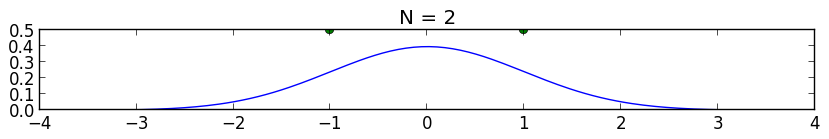

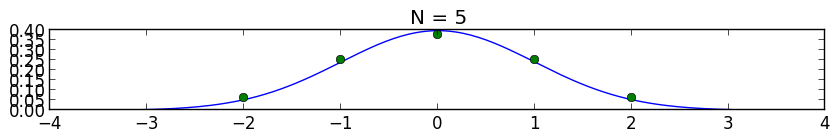

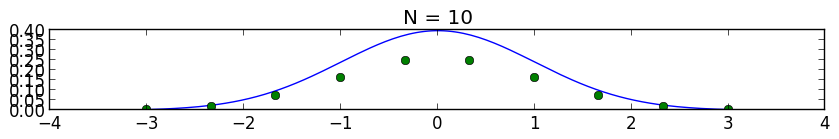

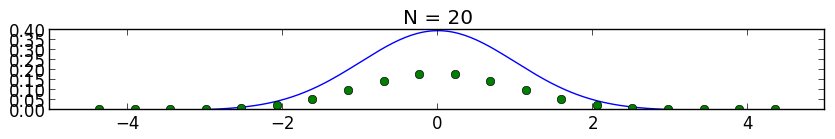

In [34]:
ρ = ρ_list[1]

autocov = Array(Float64,length(N_list),length(lag_list))
for (j,N) in enumerate(N_list)
    figure(figsize=(10,1))
    chain = alternative_rouwenhorst(N, ρ, (1-ρ^2)^(1/2))
    sim = my_simulate(chain,10000,1000);
    stat_dist = stationary_distributions(chain)[1]
    plt = plot(linspace(-4, 4, 200),pdf(Normal(),linspace(-4, 4, 200)), label=L"$z_t$")
    plot(chain.state_values,stat_dist,marker="o", ls="", label=L"$y_t$ (theoretical)")
    title("N = $N")
    
    autocov[j,:] = [cov(sim[1+lag:end],sim[1:(length(sim)-lag)]) for lag in lag_list]
    
end

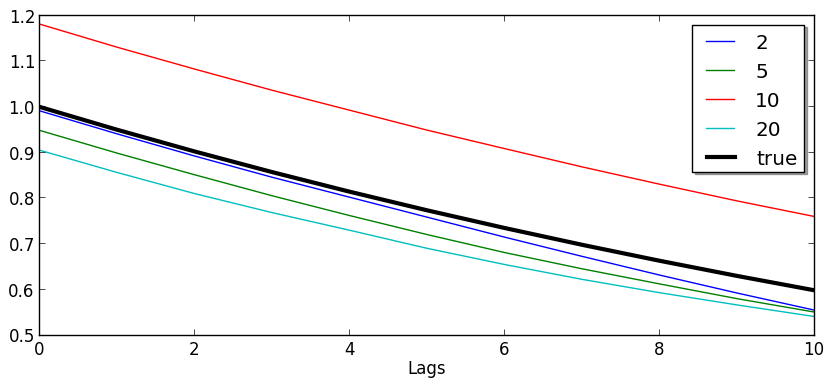

In [35]:
figure(figsize=(10,4))
for (j,N) in enumerate(N_list)
    plot(lag_list,autocov[j,:]', label="$N")
end
plot(lag_list,[ρ^lag for lag in lag_list], color="k", linewidth=3, label="true")
xlabel("Lags")
legend(loc="upper right", shadow=true);

It seems that higher N does not necessarily lead to a better fit of the autocovariance!

Now for the other choices of $\rho$:

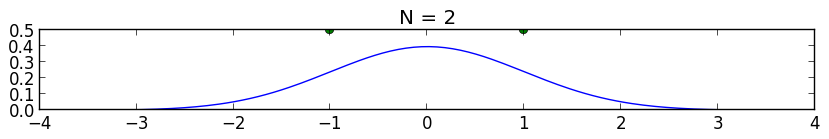

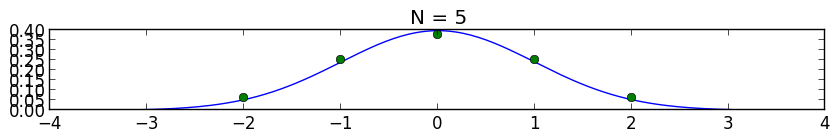

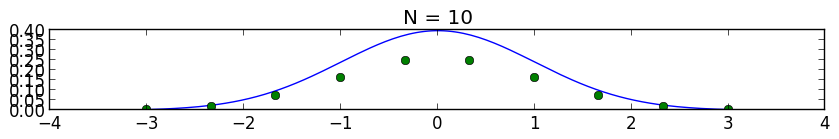

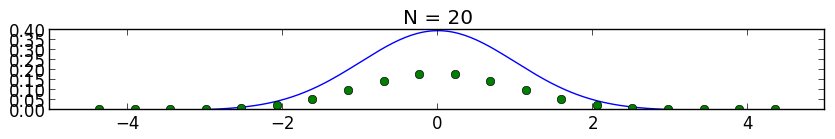

In [36]:
ρ = ρ_list[2]

autocov = Array(Float64,length(N_list),length(lag_list))
for (j,N) in enumerate(N_list)
    figure(figsize=(10,1))
    chain = alternative_rouwenhorst(N, ρ, (1-ρ^2)^(1/2))
    sim = my_simulate(chain,10000,1000);
    stat_dist = stationary_distributions(chain)[1]
    plt = plot(linspace(-4, 4, 200),pdf(Normal(),linspace(-4, 4, 200)), label=L"$z_t$")
    plot(chain.state_values,stat_dist,marker="o", ls="", label=L"$y_t$ (theoretical)")
    title("N = $N")
    
    autocov[j,:] = [cov(sim[1+lag:end],sim[1:(length(sim)-lag)]) for lag in lag_list]
    
end

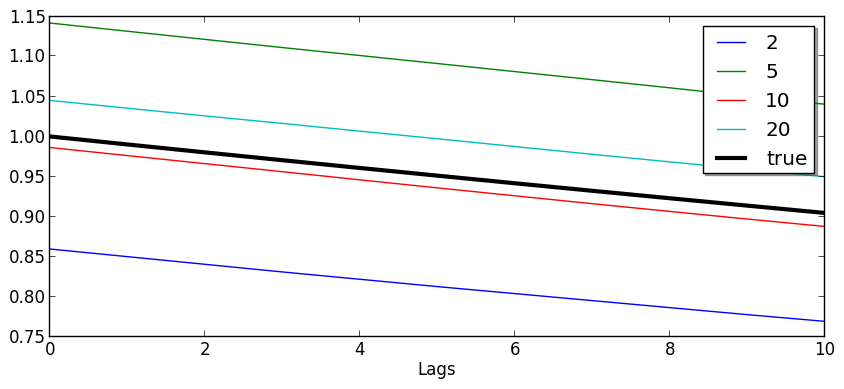

In [37]:
figure(figsize=(10,4))
for (j,N) in enumerate(N_list)
    plot(lag_list,autocov[j,:]', label="$N")
end
plot(lag_list,[ρ^lag for lag in lag_list], color="k", linewidth=3, label="true")
xlabel("Lags")
legend(loc="upper right", shadow=true);

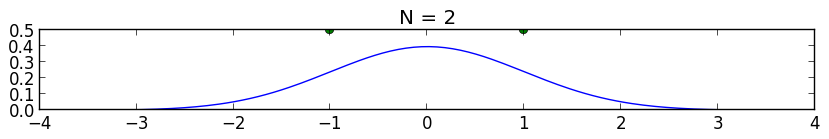

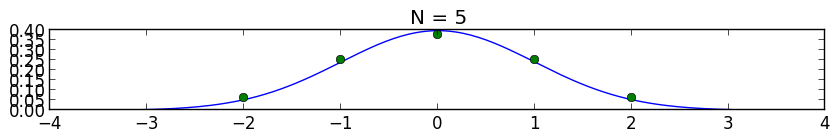

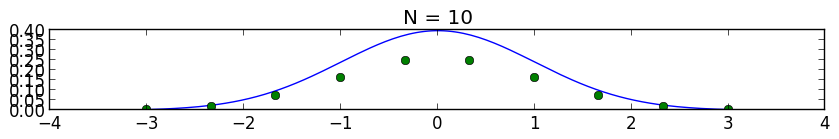

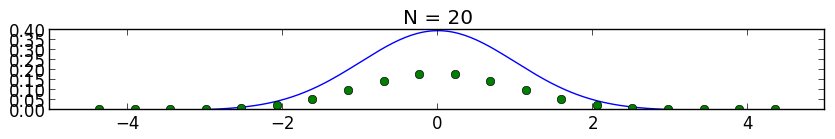

In [38]:
ρ = ρ_list[3]

autocov = Array(Float64,length(N_list),length(lag_list))
for (j,N) in enumerate(N_list)
    figure(figsize=(10,1))
    chain = alternative_rouwenhorst(N, ρ, (1-ρ^2)^(1/2))
    sim = my_simulate(chain,10000,1000);
    stat_dist = stationary_distributions(chain)[1]
    plt = plot(linspace(-4, 4, 200),pdf(Normal(),linspace(-4, 4, 200)), label=L"$z_t$")
    plot(chain.state_values,stat_dist,marker="o", ls="", label=L"$y_t$ (theoretical)")
    title("N = $N")
    
    autocov[j,:] = [cov(sim[1+lag:end],sim[1:(length(sim)-lag)]) for lag in lag_list]
    
end

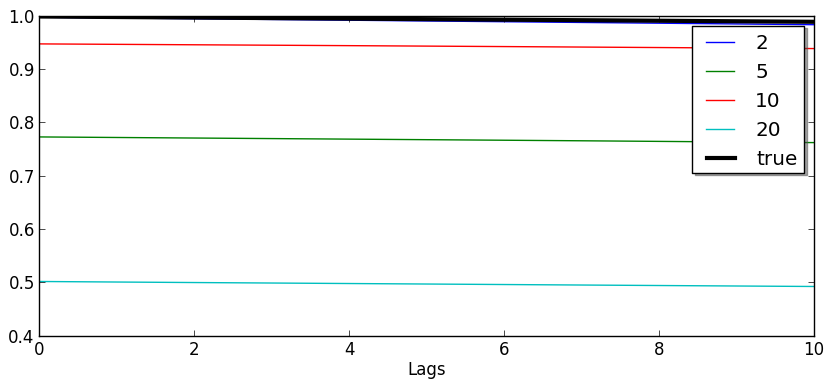

In [39]:
figure(figsize=(10,4))
for (j,N) in enumerate(N_list)
    plot(lag_list,autocov[j,:]', label="$N")
end
plot(lag_list,[ρ^lag for lag in lag_list], color="k", linewidth=3, label="true")
xlabel("Lags")
legend(loc="upper right", shadow=true);

Okay, that is weird. Let's see wheter this is a systematic error:

In [102]:
function est_auto(lag::Integer)
    chain = alternative_rouwenhorst(21,0.99,(1-0.99^2)^(1/2));
    sim = my_simulate(chain,10000,1000)
    return [cov(sim[1+lag:end],sim[1:(length(sim)-lag)])] 
end

est_auto (generic function with 1 method)

In [107]:
mean([est_auto(1) for i in 1:20])

1-element Array{Float64,1}:
 1.00044

Nope, drawing many paths and taking means give a consistent estimator for the first autocovariance. It appears that with a very high \rho properties of ergodicity get lost.

4.3.
--

The higher the $\rho$ the more dispersed the autocovariance of the single draws (time series) are.

In [40]:
alternative_rouwenhorst(6, 0.999, (1-0.999^2)^(1/2)).p

6x6 Array{Float64,2}:
 0.997502     0.002495     2.49625e-6  1.24875e-9  3.12344e-13  3.125e-17  
 0.000499001  0.997503     0.001996    1.49775e-6  4.995e-10    6.24687e-14
 2.49625e-7   0.000998002  0.997504    0.001497    7.48876e-7   1.24875e-10
 1.24875e-10  7.48876e-7   0.001497    0.997504    0.000998002  2.49625e-7 
 6.24687e-14  4.995e-10    1.49775e-6  0.001996    0.997503     0.000499001
 3.125e-17    3.12344e-13  1.24875e-9  2.49625e-6  0.002495     0.997502   

Yes, the diagonal elements are near one.